In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from slam.gridmap import GridMap
from slam.utils import bresenham_line

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)

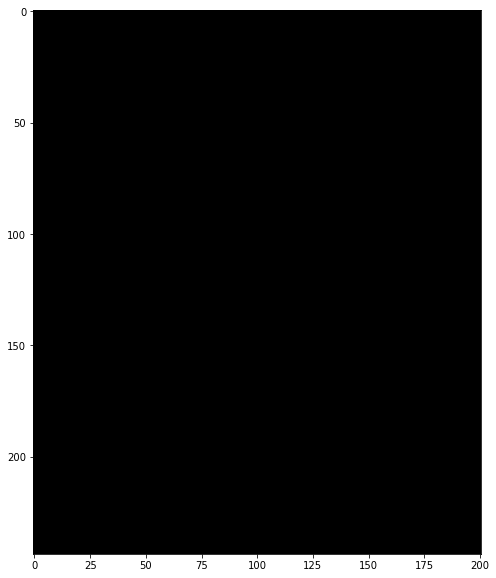

In [46]:
grid_map = GridMap('./data/laser_struct.mat')


pose_list = list(enumerate(grid_map._poses))
for t, pose in pose_list[50:54]:
    robot_pose = pose.T
    scan = grid_map._laser[0, t]
    
    map_update, pose_map_frame, laser_map_frame = grid_map.inv_sensor_model(
        scan, robot_pose
    )
    
    GridMap.laser_as_cartesian(scan)
    
    log_odds_prior = GridMap.prob2log(grid_map._prior)
    
    grid_map._grid_map = grid_map._grid_map + map_update
    
plt.imshow(grid_map._grid_map, cmap='gray')